<a href="https://colab.research.google.com/github/codrae/BEMS/blob/main/Pytorch_GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn
import torchvision.transforms as transforms
import torchvision.datasets
from torch.autograd import Variable
from torch.nn import Parameter
import torch.nn as nn
from torch import Tensor
import torch.nn.functional as F
from torch.utils.data import DataLoader
import math

import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
cuda = True if torch.cuda.is_available() else False
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

#재현성 보장을 위한 시드 설정 (난수 생성의 초기값을 고정)
torch.manual_seed(100)

if torch.cuda.is_available() :
    torch.cuda.manual_seed_all(100)

In [ ]:
# 주가 데이터 가져오기
import yfinance as yf
df = yf.download('035420.KS',
                     start='2023-06-01',
                     end='2024-06-30')

df.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-06-01,199900.0,204000.0,199900.0,204000.0,202795.718750,547388
2023-06-02,204500.0,205000.0,202500.0,204500.0,203292.765625,405330
2023-06-05,205500.0,206500.0,204000.0,204500.0,203292.765625,428762
2023-06-07,206500.0,208000.0,204000.0,205000.0,203789.828125,553505
2023-06-08,203000.0,203500.0,200000.0,200500.0,199316.390625,717690


In [ ]:
df['Close'].plot(kind='line', figsize=(8, 4), title='Naver Stock Close')

In [ ]:
# 종가 column을 제외한 DataFrame x 생성 (예측을 위한 입력 변수)
X = df.drop('Close', axis =1)  # axis =1 열을 기준으로 작업을 수행하겠다는 의미

# 종가 column만을 가지는 DataFrame y 생성 (주가 예측의 목표 변수)
y = df[['Close']]

# 훈련 데이터와 테스트 데이터셋을 분류

from sklearn.preprocessing import StandardScaler, MinMaxScaler

ms = MinMaxScaler() # 0 ~ 1
ss = StandardScaler() # 평균 0, 분산 1

X_ss = ss.fit_transform(X)
y_ms = ms.fit_transform(y)

X_train = X_ss[:74, :]
X_test = X_ss[74:, :]

y_train = y_ms[:74, :]
y_test = y_ms[74:, :]

print('Training Shape :', X_train.shape, y_train.shape)
print('Testing Shape :', X_test.shape, y_test.shape)

Training Shape : (74, 5) (74, 1)
Testing Shape : (190, 5) (190, 1)


형식을 pytorch 텐서로 변환 후, RNN계열 모델에서 사용할 수 있도록 형태를 변경
RNN 계열 모델의 입력 형태 : (batch_size, seq_length, input_size)


In [ ]:
X_train_tensors = torch.Tensor(X_train)
X_test_tensors = torch.Tensor(X_test)

y_train_tensors = torch.Tensor(y_train)
y_test_tensors = torch.Tensor(y_test)

X_train_tensors_f = torch.reshape(X_train_tensors,
                                  (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))

X_test_tensors_f = torch.reshape(X_test_tensors,
                                (X_test_tensors.shape[0], 1, X_test_tensors.shape[1]))

print('Training Shape :', X_train.shape, y_train.shape)
print('Testing Shape :', X_test.shape, y_test.shape)

Training Shape : (74, 5) (74, 1)
Testing Shape : (190, 5) (190, 1)


In [ ]:
class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM, self).__init__()
        self.num_classes = num_classes  # 출력 클래스 개수
        self.num_layers = num_layers  # LSTM 층 개수
        self.input_size = input_size  # 입력 크기 (특징 수)
        self.hidden_size = hidden_size  # 은닉층의 뉴런 개수
        self.seq_length = seq_length  # 시퀀스 길이

        # LSTM 계층 정의
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)

        # 완전 연결층 정의
        self.fc_1 = nn.Linear(hidden_size, 128)
        self.fc = nn.Linear(128, num_classes)
        self.relu = nn.ReLU() # 활성화 함수

    def forward(self, x):
        # 은닉 상태 및 셀 상태 초기화 (배치 크기에 따라 동적으로 생성)
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_()
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_()

        # LSTM 계층에 입력 및 초기 상태 적용
        output, (hn, cn) = self.lstm(x, (h_0, c_0))

        # 최종 은닉 상태를 완전 연결층에 입력하기 위해 2차원 텐서로 변환
        hn = hn[-1]  # 최종 LSTM 층의 마지막 은닉 상태만 사용

        # 완전 연결층을 통과시키기 전에 ReLU 활성화 함수 적용
        out = self.relu(hn)
        out = self.fc_1(out)
        out = self.relu(out)

        # 최종 출력층 통과
        out = self.fc(out)

        return out


In [ ]:
num_epochs = 10000
lr = 0.0001



input_size=5 # 칼럼 개수
hidden_size=2 # 은닉층 유닛 개수
num_layers= 1 # LSTM 계층 개수

num_classes=1 # 클래스 개수
model = LSTM(num_classes, input_size, hidden_size, num_layers, X_train_tensors_f.shape[1])

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr)

In [ ]:
for epoch in range(num_epochs) :
    outputs = model(X_train_tensors_f)
    optimizer.zero_grad()
    loss = criterion(outputs, y_train_tensors)# 손실값 계산
    loss.backward()

    optimizer.step()
    if epoch % 100 == 0 :
        print(f'Epoch : {epoch}, loss : {loss.item():1.5f}')

Epoch : 0, loss : 0.23880
Epoch : 100, loss : 0.08727
Epoch : 200, loss : 0.04075
Epoch : 300, loss : 0.03140
Epoch : 400, loss : 0.02891
Epoch : 500, loss : 0.02661
Epoch : 600, loss : 0.02390
Epoch : 700, loss : 0.02092
Epoch : 800, loss : 0.01795
Epoch : 900, loss : 0.01532
Epoch : 1000, loss : 0.01332
Epoch : 1100, loss : 0.01185
Epoch : 1200, loss : 0.01067
Epoch : 1300, loss : 0.00978
Epoch : 1400, loss : 0.00906
Epoch : 1500, loss : 0.00845
Epoch : 1600, loss : 0.00793
Epoch : 1700, loss : 0.00746
Epoch : 1800, loss : 0.00702
Epoch : 1900, loss : 0.00652
Epoch : 2000, loss : 0.00600
Epoch : 2100, loss : 0.00541
Epoch : 2200, loss : 0.00466
Epoch : 2300, loss : 0.00384
Epoch : 2400, loss : 0.00318
Epoch : 2500, loss : 0.00266
Epoch : 2600, loss : 0.00228
Epoch : 2700, loss : 0.00201
Epoch : 2800, loss : 0.00182
Epoch : 2900, loss : 0.00168
Epoch : 3000, loss : 0.00156
Epoch : 3100, loss : 0.00148
Epoch : 3200, loss : 0.00142
Epoch : 3300, loss : 0.00137
Epoch : 3400, loss : 0.001

In [ ]:
# 데이터 표준화 및 정규화
df_x_ss = ss.transform(X)
df_y_ms = ms.transform(y)

# Numpy 배열을 PyTorch 텐서로 변환
df_x_ss = torch.tensor(df_x_ss, dtype=torch.float32)
df_y_ms = torch.tensor(df_y_ms, dtype=torch.float32)

# 텐서의 모양을 (batch_size, seq_length, input_size)로 재구성
df_x_ss = df_x_ss.unsqueeze(1)  # (batch_size, 1, input_size)로 변환


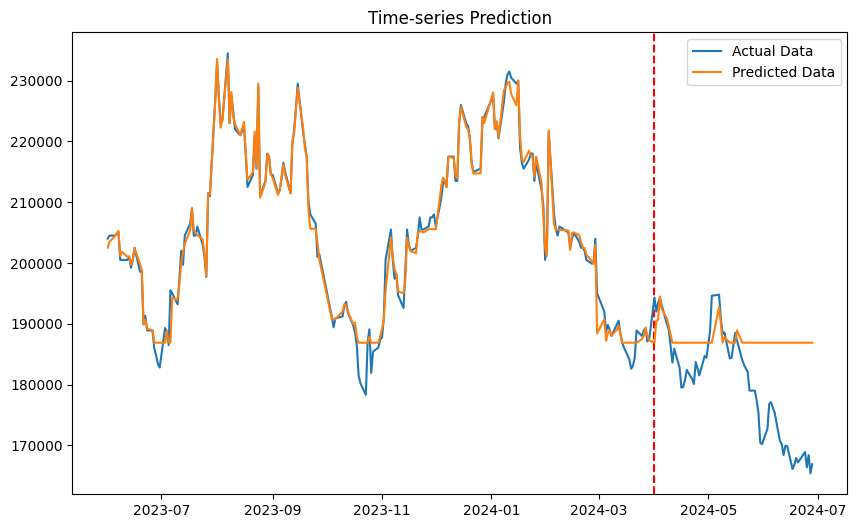

In [ ]:
train_predict = model(df_x_ss)
predicted = train_predict.data.numpy()

label_y = df_y_ms.data.numpy()

predicted = ms.inverse_transform(predicted)
label_y = ms.inverse_transform(label_y)
plt.figure(figsize=(10, 6))
plt.axvline(x=datetime(2024,4,1), c='r', linestyle='--')

df['pred'] = predicted
plt.plot(df['Close'], label='Actual Data')
plt.plot(df['pred'], label='Predicted Data')

plt.title('Time-series Prediction')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 모델이 예측한 값 (predicted)과 실제 값 (label_y)의 성능 평가
mse = mean_squared_error(label_y, predicted)
mae = mean_absolute_error(label_y, predicted)
r2 = r2_score(label_y, predicted)

# 성능 지표 출력
print("Model Performance:")
print(f" - Mean Squared Error (MSE): {mse:.4f}")
print(f" - Mean Absolute Error (MAE): {mae:.4f}")
print(f" - R-squared (R²): {r2:.4f}")


Model Performance:
 - Mean Squared Error (MSE): 30052488.0000
 - Mean Absolute Error (MAE): 2747.1809
 - R-squared (R²): 0.8914


In [ ]:
class GRU(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(GRU, self).__init__()
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length

        # GRU 레이어
        self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True)

        # 완전 연결층
        self.fc_1 = nn.Linear(hidden_size, 128)
        self.fc = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        # 초기 은닉 상태 설정 (device에 맞게 초기화)
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # GRU 레이어 통과
        output, hn = self.gru(x, h_0)

        # hn은 (num_layers, batch_size, hidden_size) 크기이므로, 가장 마지막 레이어의 출력을 사용
        hn = hn[-1]

        # 완전 연결층을 통과
        out = self.relu(hn)
        out = self.fc_1(out)
        out = self.relu(out)
        out = self.fc(out)

        return out


In [ ]:
# 하이퍼파라미터 설정
num_epochs = 10000
learning_rate = 0.0001

input_size = 5  # 입력 특징 수
hidden_size = 2  # GRU의 은닉 상태 크기
num_layers = 1  # GRU 레이어 수
num_classes = 1  # 출력 클래스 수

# 모델 초기화
model = GRU(num_classes, input_size, hidden_size, num_layers, X_train_tensors_f.shape[1])

# 손실 함수 및 최적화 알고리즘 설정
criterion = torch.nn.MSELoss()  # 회귀 문제를 위한 평균 제곱 오차(MSE) 손실 함수
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  # Adam 옵티마이저


In [ ]:
# 모델 학습 루프
for epoch in range(num_epochs):
    model.train()  # 모델을 학습 모드로 설정
    outputs = model(X_train_tensors_f)  # 전방향 학습 (forward pass)

    optimizer.zero_grad()  # 기울기 초기화
    loss = criterion(outputs, y_train_tensors)  # 손실 계산
    loss.backward()  # 기울기 계산 (역방향 전파)

    optimizer.step()  # 가중치 업데이트

    # 100 에포크마다 손실 출력
    if epoch % 100 == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item():.5f}')


Epoch: 0, Loss: 0.62679
Epoch: 100, Loss: 0.28728
Epoch: 200, Loss: 0.12235
Epoch: 300, Loss: 0.05777
Epoch: 400, Loss: 0.03874
Epoch: 500, Loss: 0.03448
Epoch: 600, Loss: 0.03336
Epoch: 700, Loss: 0.03252
Epoch: 800, Loss: 0.03138
Epoch: 900, Loss: 0.02977
Epoch: 1000, Loss: 0.02762
Epoch: 1100, Loss: 0.02461
Epoch: 1200, Loss: 0.02045
Epoch: 1300, Loss: 0.01670
Epoch: 1400, Loss: 0.01387
Epoch: 1500, Loss: 0.01194
Epoch: 1600, Loss: 0.01084
Epoch: 1700, Loss: 0.01020
Epoch: 1800, Loss: 0.00982
Epoch: 1900, Loss: 0.00955
Epoch: 2000, Loss: 0.00934
Epoch: 2100, Loss: 0.00902
Epoch: 2200, Loss: 0.00865
Epoch: 2300, Loss: 0.00830
Epoch: 2400, Loss: 0.00796
Epoch: 2500, Loss: 0.00764
Epoch: 2600, Loss: 0.00734
Epoch: 2700, Loss: 0.00702
Epoch: 2800, Loss: 0.00669
Epoch: 2900, Loss: 0.00639
Epoch: 3000, Loss: 0.00612
Epoch: 3100, Loss: 0.00588
Epoch: 3200, Loss: 0.00567
Epoch: 3300, Loss: 0.00547
Epoch: 3400, Loss: 0.00528
Epoch: 3500, Loss: 0.00511
Epoch: 3600, Loss: 0.00494
Epoch: 3700, 

In [ ]:
  # 데이터 전처리: 표준화된 데이터를 Tensor로 변환하고 reshape 수행
  df_x_ss = torch.tensor(ss.transform(X), dtype=torch.float32)  # 입력 데이터를 표준화하고 Tensor로 변환
  df_y_ms = torch.tensor(ms.transform(y), dtype=torch.float32)  # 출력 데이터를 표준화하고 Tensor로 변환

  # 입력 텐서의 모양을 (batch_size, seq_length, input_size)로 변환
  df_x_ss = df_x_ss.unsqueeze(1)  # 첫 번째 차원에 시퀀스 길이 차원을 추가 (기본적으로 1차원)


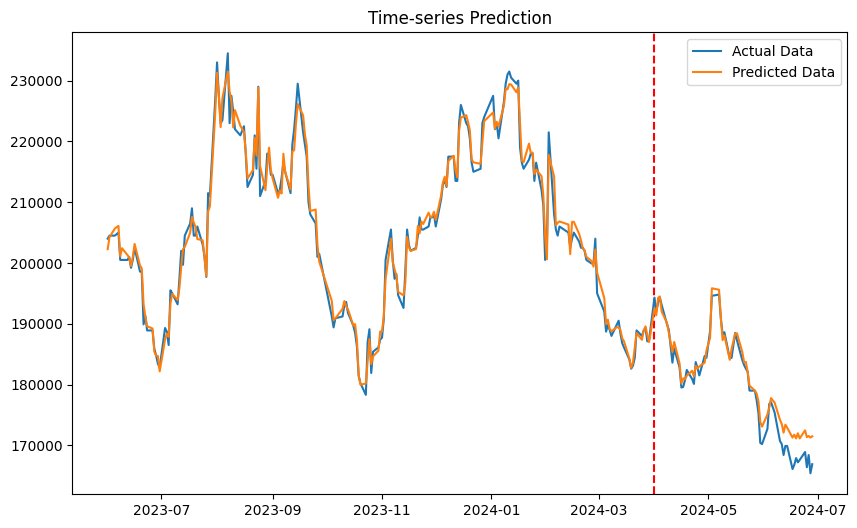

In [ ]:
# 모델을 사용하여 예측 수행
train_predict = model(df_x_ss)

# 텐서를 넘파이 배열로 변환
predicted = train_predict.detach().numpy()  # 텐서를 넘파이 배열로 변환 (기울기 추적 비활성화)
label_y = df_y_ms.detach().numpy()  # 텐서를 넘파이 배열로 변환

# 예측값과 실제값을 원래 스케일로 되돌림
predicted = ms.inverse_transform(predicted)
label_y = ms.inverse_transform(label_y)

# 결과 시각화
plt.figure(figsize=(10, 6))

# 특정 날짜에 빨간 세로선 추가
plt.axvline(x=datetime(2024, 4, 1), color='r', linestyle='--')

# 데이터프레임에 예측값 추가
df['pred'] = predicted

# 실제 데이터와 예측 데이터를 플롯
plt.plot(df['Close'], label='Actual Data')
plt.plot(df['pred'], label='Predicted Data')

# 그래프 제목과 범례 설정
plt.title('Time-series Prediction')
plt.legend()
plt.show()


In [ ]:
# 모델이 예측한 값 (predicted)과 실제 값 (label_y)의 성능 평가
mse = mean_squared_error(label_y, predicted)
mae = mean_absolute_error(label_y, predicted)
r2 = r2_score(label_y, predicted)

# 성능 지표 출력
print("Model Performance:")
print(f" - Mean Squared Error (MSE): {mse:.4f}")
print(f" - Mean Absolute Error (MAE): {mae:.4f}")
print(f" - R-squared (R²): {r2:.4f}")


Model Performance:
 - Mean Squared Error (MSE): 3412547.0000
 - Mean Absolute Error (MAE): 1401.7717
 - R-squared (R²): 0.9877


In [ ]:
torch.save(model.state_dict(), "gru_naver.h5")